In [145]:
import time
import getpass
username = getpass.getuser()
start_time = time.time()
#Where is the data?
if username == "bdutt":
    baseDir="/Users/bdutt/Documents/workspace-whitespace/face/face/data/lfw"
elif username =="cgarg":
    baseDir="/Users/cgarg/Documents/charu/intuit/code/face/data/lfw"
flow = "main"
debug = False

%run "Load Data.ipynb"

filenames = []
labels = []

def collectFileNamesAndLabels(filename):
    filenames.append(filename)
    result = filename.split("/") 
    labels.append(result[len(result)-2]) #Get the label name from filename
    

doForEachFile(collectFileNamesAndLabels,baseDir, 1000)
print("Total File name collection time = %s seconds" % (time.time() - start_time))
print ("Files collected : ",len(filenames))

Total File name collection time = 0.06949186325073242 seconds
Files collected :  647


In [146]:
start_time = time.time()
imagesList = []
doForEachFileNames(readImage, filenames, imagesList)
print ("Images data collected : ",len(imagesList))
print("Total data collection time = %s seconds" % (time.time() - start_time))

Images data collected :  647
Total data collection time = 2.412548065185547 seconds


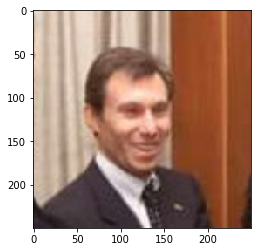

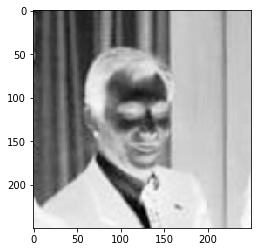

Total dataframe creation time = 22.314621925354004 seconds


In [147]:
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


Y = pd.DataFrame(labels, columns = ['name'])
sizeOfYLabel = len(Y)
oneDImageList = []
showOneImage = True
for image in imagesList:
    # Convert RGB to single number
    if showOneImage:
        plt.imshow(image, cmap="Greys")
        plt.show()
    gray = rgb2gray(image)
    if showOneImage:
        plt.imshow(gray, cmap="Greys")
        plt.show()
        showOneImage = False
    oneDImageList.append(gray.flatten())
    
del imagesList

X = pd.DataFrame(oneDImageList)
del oneDImageList
print("Total dataframe creation time = %s seconds" % (time.time() - start_time))



In [167]:
# Y.groupby('name').count()
Y['name'].value_counts()

Jennifer_Aniston      21
Andy_Roddick          15
Dick_Cheney           14
Salma_Hayek           13
Queen_Elizabeth_II    13
                      ..
Din_Samsudin           1
Takuma_Sato            1
Ray_Lewis              1
Stephane_Rousseau      1
Frank_Van_Ecke         1
Name: name, Length: 355, dtype: int64

In [180]:
maxFrequency = 21
X_sample = pd.DataFrame(columns = X.columns)
Y_sample = pd.DataFrame(columns = Y.columns)
for label in Y['name'].unique():
#     print(label)
    dfa = X[Y['name']== label]
    dfasample = dfa.sample(n=maxFrequency,replace=True)
    dfb = Y[Y['name']== label]
    dfbsample = dfb.sample(n=maxFrequency,replace=True)
#     print(dfasample)
    if X_sample.empty:
        X_sample = dfasample
        Y_sample = dfbsample
    else:    
        print(X_sample.shape)
        print(Y_sample.shape)
        X_sample = X_sample.append(dfasample)
        Y_sample= Y_sample.append(dfbsample)

print(X_sample.shape)
print(Y_sample.shape)
# print(X_sample)

(21, 62500)
(21, 1)
(42, 62500)
(42, 1)
(63, 62500)
(63, 1)
(84, 62500)
(84, 1)
(105, 62500)
(105, 1)
(126, 62500)
(126, 1)
(147, 62500)
(147, 1)
(168, 62500)
(168, 1)
(189, 62500)
(189, 1)
(210, 62500)
(210, 1)
(231, 62500)
(231, 1)
(252, 62500)
(252, 1)
(273, 62500)
(273, 1)
(294, 62500)
(294, 1)
(315, 62500)
(315, 1)
(336, 62500)
(336, 1)
(357, 62500)
(357, 1)
(378, 62500)
(378, 1)
(399, 62500)
(399, 1)
(420, 62500)
(420, 1)
(441, 62500)
(441, 1)
(462, 62500)
(462, 1)
(483, 62500)
(483, 1)
(504, 62500)
(504, 1)
(525, 62500)
(525, 1)
(546, 62500)
(546, 1)
(567, 62500)
(567, 1)
(588, 62500)
(588, 1)
(609, 62500)
(609, 1)
(630, 62500)
(630, 1)
(651, 62500)
(651, 1)
(672, 62500)
(672, 1)
(693, 62500)
(693, 1)
(714, 62500)
(714, 1)
(735, 62500)
(735, 1)
(756, 62500)
(756, 1)
(777, 62500)
(777, 1)
(798, 62500)
(798, 1)
(819, 62500)
(819, 1)
(840, 62500)
(840, 1)
(861, 62500)
(861, 1)
(882, 62500)
(882, 1)
(903, 62500)
(903, 1)
(924, 62500)
(924, 1)
(945, 62500)
(945, 1)
(966, 62500)
(966,

(7287, 62500)
(7287, 1)
(7308, 62500)
(7308, 1)
(7329, 62500)
(7329, 1)
(7350, 62500)
(7350, 1)
(7371, 62500)
(7371, 1)
(7392, 62500)
(7392, 1)
(7413, 62500)
(7413, 1)
(7434, 62500)
(7434, 1)
(7455, 62500)
(7455, 1)


In [216]:
start_time = time.time()
sizeOfX = 62500
%run "DNN.ipynb"

print("Total DNN time = %s seconds" % (time.time() - start_time))

Shape of X to DNN (7455, 62500)
Shape of Y to DNN (7455, 1)
Shape of Y post OneHot encoding (7455, 355)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 50)                3125050   
_________________________________________________________________
dense_62 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_21 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 355)               9230      
Total params: 3,135,555
Trainable params: 3,135,555
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
7455/7455 [==============================] - 16s 2ms/step - loss: 0.6817 - accuracy: 0.5678
Epoch 2/250
7455/7455 [==========

7455/7455 [==============================] - 25s 3ms/step - loss: 0.0209 - accuracy: 0.9971
Epoch 70/250
7455/7455 [==============================] - 24s 3ms/step - loss: 0.0209 - accuracy: 0.9971
Epoch 71/250
7455/7455 [==============================] - 26s 4ms/step - loss: 0.0205 - accuracy: 0.9971
Epoch 72/250
7455/7455 [==============================] - 23s 3ms/step - loss: 0.0205 - accuracy: 0.9971
Epoch 73/250
7455/7455 [==============================] - 24s 3ms/step - loss: 0.0205 - accuracy: 0.9971
Epoch 74/250
7455/7455 [==============================] - 22s 3ms/step - loss: 0.0202 - accuracy: 0.9971
Epoch 75/250
7455/7455 [==============================] - 20s 3ms/step - loss: 0.0203 - accuracy: 0.9971
Epoch 76/250
7455/7455 [==============================] - 17s 2ms/step - loss: 0.0202 - accuracy: 0.9971
Epoch 77/250
7455/7455 [==============================] - 18s 2ms/step - loss: 0.0198 - accuracy: 0.9971
Epoch 78/250
7455/7455 [==============================] - 19s 3ms/st

7455/7455 [==============================] - 15s 2ms/step - loss: 0.0146 - accuracy: 0.9972
Epoch 147/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0145 - accuracy: 0.9972
Epoch 148/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0145 - accuracy: 0.9972
Epoch 149/250
7455/7455 [==============================] - 14s 2ms/step - loss: 0.0145 - accuracy: 0.9972
Epoch 150/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0143 - accuracy: 0.9972
Epoch 151/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0143 - accuracy: 0.9972
Epoch 152/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0141 - accuracy: 0.9972
Epoch 153/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0142 - accuracy: 0.9972
Epoch 154/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0141 - accuracy: 0.9972
Epoch 155/250
7455/7455 [==============================] - 1

7455/7455 [==============================] - 15s 2ms/step - loss: 0.0107 - accuracy: 0.9973
Epoch 224/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0108 - accuracy: 0.9973
Epoch 225/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0107 - accuracy: 0.9973
Epoch 226/250
7455/7455 [==============================] - 14s 2ms/step - loss: 0.0108 - accuracy: 0.9973
Epoch 227/250
7455/7455 [==============================] - 14s 2ms/step - loss: 0.0107 - accuracy: 0.9973
Epoch 228/250
7455/7455 [==============================] - 14s 2ms/step - loss: 0.0106 - accuracy: 0.9973
Epoch 229/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 230/250
7455/7455 [==============================] - 15s 2ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 231/250
7455/7455 [==============================] - 14s 2ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 232/250
7455/7455 [==============================] - 1

In [183]:
# print(Y)
enc.get_feature_names(['name'])
print(enc.get_feature_names(['name']).shape)

(355,)


In [217]:
# predictions1 = model.predict(X.iloc[1:2,:])
# predictions2 = model.predict(X.iloc[2:3, :])
# print(predictions1)
# print(predictions2)
import numpy as np
# from keras.models import callbacks
import tensorflow as tf
historyList = []
historyList.append(tf.keras.callbacks.History())
for i in range(300):
#     print(model.predict(X.iloc[i:i+1,:]))
    prediction = model.predict(X_sample.iloc[i:i+1,:],verbose=0, callbacks=historyList)
    print(prediction.shape)
#     print(type(prediction))
    class_labels = np.argmax(prediction[0], axis=0)
    print(class_labels)
    print(enc.get_feature_names(['name'])[class_labels]," Names of class :: ", Y_sample.iloc[i].values)

(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
116
name_German_Khan  Names of class ::  ['German_Khan']
(1, 355)
1

(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newhart  Names of class ::  ['Bob_Newhart']
(1, 355)
31
name_Bob_Newh

(1, 355)
111
name_Geoff_Hoon  Names of class ::  ['Ranil_Wickremasinghe']
(1, 355)
111
name_Geoff_Hoon  Names of class ::  ['Ranil_Wickremasinghe']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::  ['Ben_Chandler']
(1, 355)
21
name_Ben_Chandler  Names of class ::